# Brain Tumor MRI Classification

## Part 1: Exploratory Data Analysis and Data Preprocessing

### Project Introduction

This project aims to classify brain tumors from MRI images into four distinct categories: Glioma, Meningioma, No Tumor, and Pituitary. In this first notebook, we establish the data pipeline, perform exploratory data analysis (EDA), and prepare the images for the deep learning training phase.

### 1. Library Imports and Environment Setup

We begin by importing the necessary libraries for data manipulation, computer vision, and deep learning. We also configure the environment for reproducibility and GPU acceleration.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# TensorFlow & Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 2. Dataset Extraction

The dataset is provided in a compressed ZIP format. The following utility function identifies the dataset in the local environment and extracts it into the working directory.

In [ ]:
import zipfile
import glob

def extract_dataset_zip():
    """
    Search and extract dataset ZIP file in /content/
    """
    print("Searching for ZIP file in /content/\n")

    # Search for all zip files in /content/
    zip_files = glob.glob('/content/*.zip')

    if not zip_files:
        print("No ZIP file found in /content/")
        print("Please upload your dataset ZIP file to Colab runtime")
        return False

    # Show found ZIP files
    print(f"Found {len(zip_files)} ZIP file(s):")
    for i, zip_path in enumerate(zip_files, 1):
        zip_size = os.path.getsize(zip_path) / (1024**3)  # Convert to GB
        print(f"   {i}. {os.path.basename(zip_path)} ({zip_size:.2f} GB)")

    # Use first ZIP file
    if len(zip_files) > 1:
        zip_path = max(zip_files, key=os.path.getsize)
        print(f"\nMultiple ZIP files found. Using largest: {os.path.basename(zip_path)}")
    else:
        zip_path = zip_files[0]
        print(f"\nUsing: {os.path.basename(zip_path)}")

    # Extract ZIP
    print(f"\nExtracting ZIP file... (this may take 2-3 minutes)")

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            file_list = zip_ref.namelist()
            total_files = len(file_list)

            print(f"   Total files in ZIP: {total_files:,}")
            print(f"   Extracting to: /content/")

            zip_ref.extractall('/content/')

            print(f"\nExtraction completed successfully!")
            print(f"   Extracted {total_files:,} files")

            print(f"\nExtracted contents:")
            extracted_items = [item for item in os.listdir('/content/')
                             if os.path.isdir(os.path.join('/content/', item))
                             and item not in ['sample_data', '.config']]
            for item in extracted_items:
                print(f"   - {item}/")

            return True

    except zipfile.BadZipFile:
        print(f"ERROR: {os.path.basename(zip_path)} is not a valid ZIP file")
        return False
    except Exception as e:
        print(f"ERROR during extraction: {str(e)}")
        return False

# Run extraction
if extract_dataset_zip():
    print("\nDataset ready for processing!")
else:
    print("\nPlease upload the dataset ZIP file and run this cell again")


Searching for ZIP file in /content/

Found 1 ZIP file(s):
   1. archive (6).zip (0.15 GB)

Using: archive (6).zip

Extracting ZIP file... (this may take 2-3 minutes)
   Total files in ZIP: 7,023
   Extracting to: /content/

Extraction completed successfully!
   Extracted 7,023 files

Extracted contents:
   - drive/
   - Testing/
   - Training/

Dataset ready for processing!


### 3. Dataset Verification

We verify the integrity of the extracted folders to ensure the Training and Testing splits exist with the correct class subdirectories.

In [ ]:
def verify_dataset_structure(base_path='/content'):
    """
    Verify dataset structure and display information
    """
    train_path = os.path.join(base_path, 'Training')
    test_path = os.path.join(base_path, 'Testing')

    print("Verifying Dataset Structure...\n")

    if not os.path.exists(train_path):
        print("ERROR: Training folder not found!")
        return False

    if not os.path.exists(test_path):
        print("ERROR: Testing folder not found!")
        return False

    expected_classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

    print("Training folder found")
    train_classes = sorted(os.listdir(train_path))
    print(f"   Classes: {train_classes}")

    print("\nTesting folder found")
    test_classes = sorted(os.listdir(test_path))
    print(f"   Classes: {test_classes}")

    for cls in expected_classes:
        if cls not in train_classes:
            print(f"\nWARNING: Class '{cls}' not found in Training folder")
        if cls not in test_classes:
            print(f"WARNING: Class '{cls}' not found in Testing folder")

    print("\nDataset structure verified successfully!")
    return True

# Run verification
if verify_dataset_structure():
    TRAIN_DIR = '/content/Training'
    TEST_DIR = '/content/Testing'
    print(f"\nTraining Directory: {TRAIN_DIR}")
    print(f"Testing Directory: {TEST_DIR}")
else:
    print("\nPlease upload the dataset following the instructions above")


Verifying Dataset Structure...

Training folder found
   Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']

Testing folder found
   Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']

Dataset structure verified successfully!

Training Directory: /content/Training
Testing Directory: /content/Testing


### 4. Exploratory Data Analysis (EDA)

Understanding the dataset distribution is vital. We calculate the sample count for each class across the Training and Testing sets to check for class imbalance.

In [ ]:
def load_dataset_info(train_dir, test_dir):
    """
    Load dataset information and create DataFrame for analysis
    """
    classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

    data_info = {
        'class': [],
        'split': [],
        'count': [],
        'path': []
    }

    # Training data
    for cls in classes:
        cls_path = os.path.join(train_dir, cls)
        if os.path.exists(cls_path):
            count = len(os.listdir(cls_path))
            data_info['class'].append(cls)
            data_info['split'].append('Training')
            data_info['count'].append(count)
            data_info['path'].append(cls_path)

    # Testing data
    for cls in classes:
        cls_path = os.path.join(test_dir, cls)
        if os.path.exists(cls_path):
            count = len(os.listdir(cls_path))
            data_info['class'].append(cls)
            data_info['split'].append('Testing')
            data_info['count'].append(count)
            data_info['path'].append(cls_path)

    df = pd.DataFrame(data_info)
    return df

# Load dataset information
df_info = load_dataset_info(TRAIN_DIR, TEST_DIR)

print("\nDATASET OVERVIEW")
print(df_info.to_string(index=False))

# Summary statistics
print("\nSUMMARY STATISTICS")
train_total = df_info[df_info['split'] == 'Training']['count'].sum()
test_total = df_info[df_info['split'] == 'Testing']['count'].sum()
total_images = train_total + test_total

print(f"Total Training Images: {train_total:,}")
print(f"Total Testing Images: {test_total:,}")
print(f"Total Images: {total_images:,}")
print(f"Number of Classes: {df_info['class'].nunique()}")
print(f"Train/Test Ratio: {train_total/test_total:.2f}")



DATASET OVERVIEW
     class    split  count                         path
    glioma Training   1321     /content/Training/glioma
meningioma Training   1339 /content/Training/meningioma
   notumor Training   1595    /content/Training/notumor
 pituitary Training   1457  /content/Training/pituitary
    glioma  Testing    300      /content/Testing/glioma
meningioma  Testing    306  /content/Testing/meningioma
   notumor  Testing    405     /content/Testing/notumor
 pituitary  Testing    300   /content/Testing/pituitary

SUMMARY STATISTICS
Total Training Images: 5,712
Total Testing Images: 1,311
Total Images: 7,023
Number of Classes: 4
Train/Test Ratio: 4.36


### 5. Class Distribution Visualization

Visualizing the counts through bar charts and pie charts helps in identifying the proportions of each tumor type within the dataset splits.


Generating visualizations...


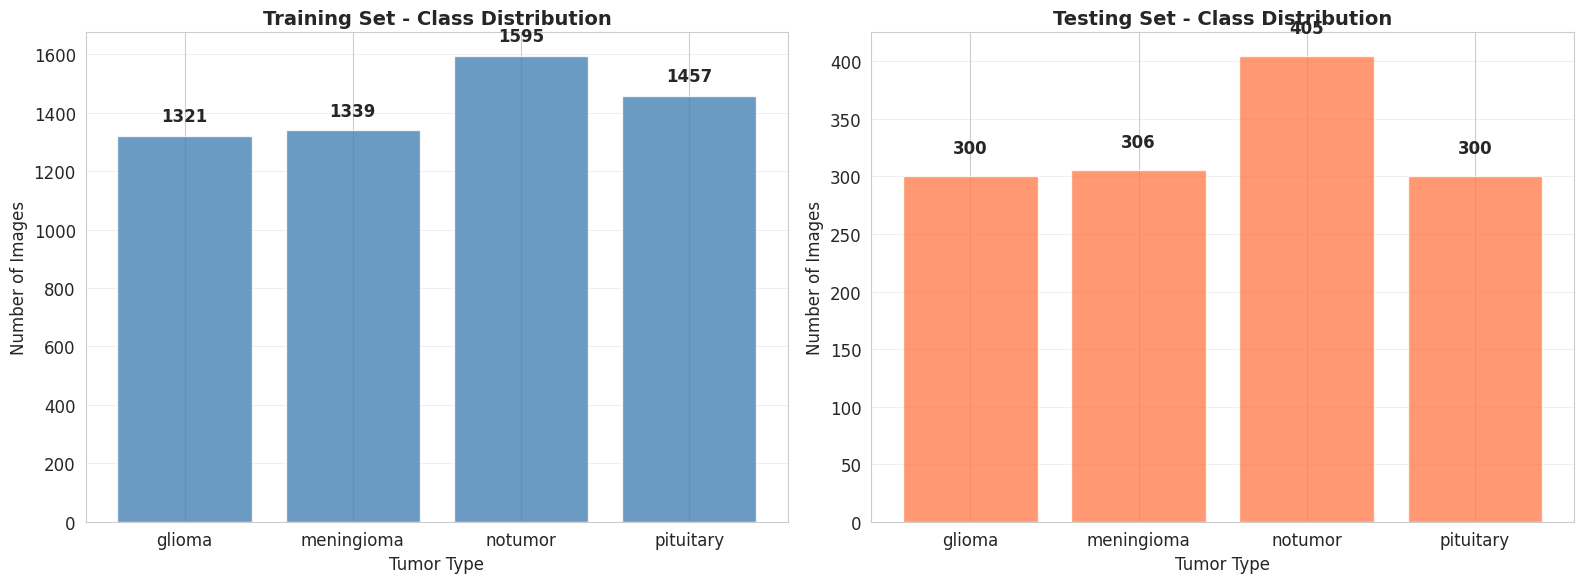

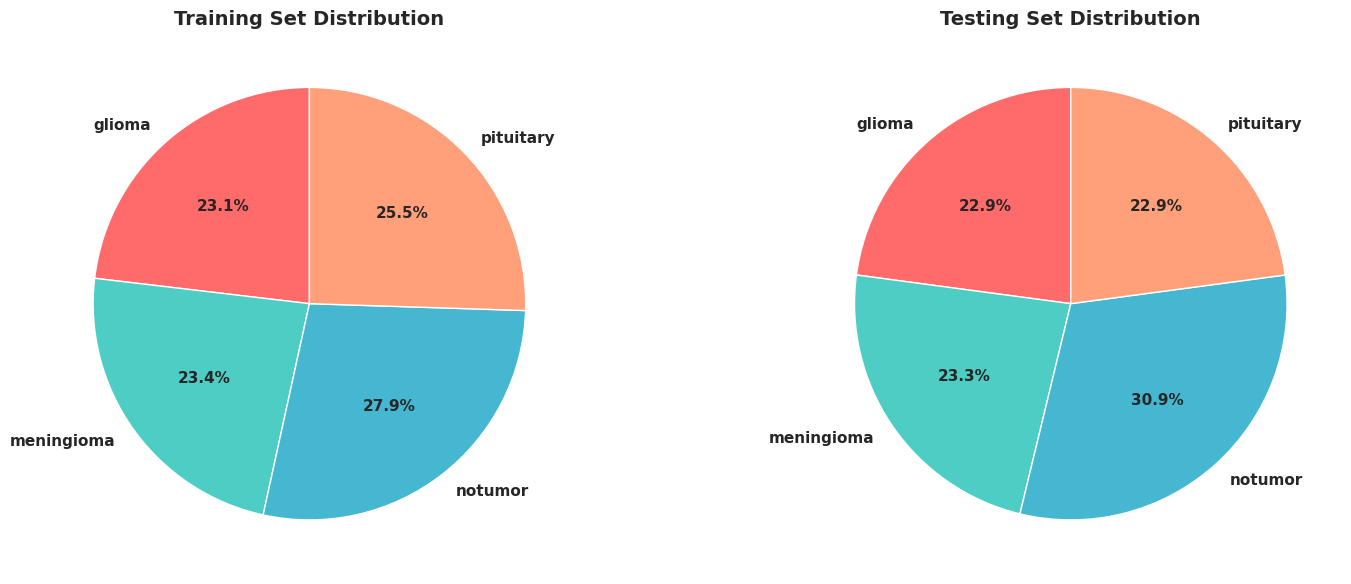

In [ ]:
print("\nGenerating visualizations...")

# Create pivot table for visualization
df_pivot = df_info.pivot(index='class', columns='split', values='count')

# Plot 1: Class Distribution Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training distribution
train_data = df_info[df_info['split'] == 'Training']
axes[0].bar(train_data['class'], train_data['count'], color='steelblue', alpha=0.8)
axes[0].set_title('Training Set - Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Tumor Type', fontsize=12)
axes[0].set_ylabel('Number of Images', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(train_data['count']):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Testing distribution
test_data = df_info[df_info['split'] == 'Testing']
axes[1].bar(test_data['class'], test_data['count'], color='coral', alpha=0.8)
axes[1].set_title('Testing Set - Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Tumor Type', fontsize=12)
axes[1].set_ylabel('Number of Images', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(test_data['count']):
    axes[1].text(i, v + 20, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Plot 2: Pie charts
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

axes[0].pie(train_data['count'], labels=train_data['class'], autopct='%1.1f%%',
            colors=colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[0].set_title('Training Set Distribution', fontsize=14, fontweight='bold')

axes[1].pie(test_data['count'], labels=test_data['class'], autopct='%1.1f%%',
            colors=colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Testing Set Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


### 6. Visual Inspection of MRI Samples

Inspecting raw images is a crucial step to understand the visual differences between classes and to check for image artifacts.


Displaying sample images...


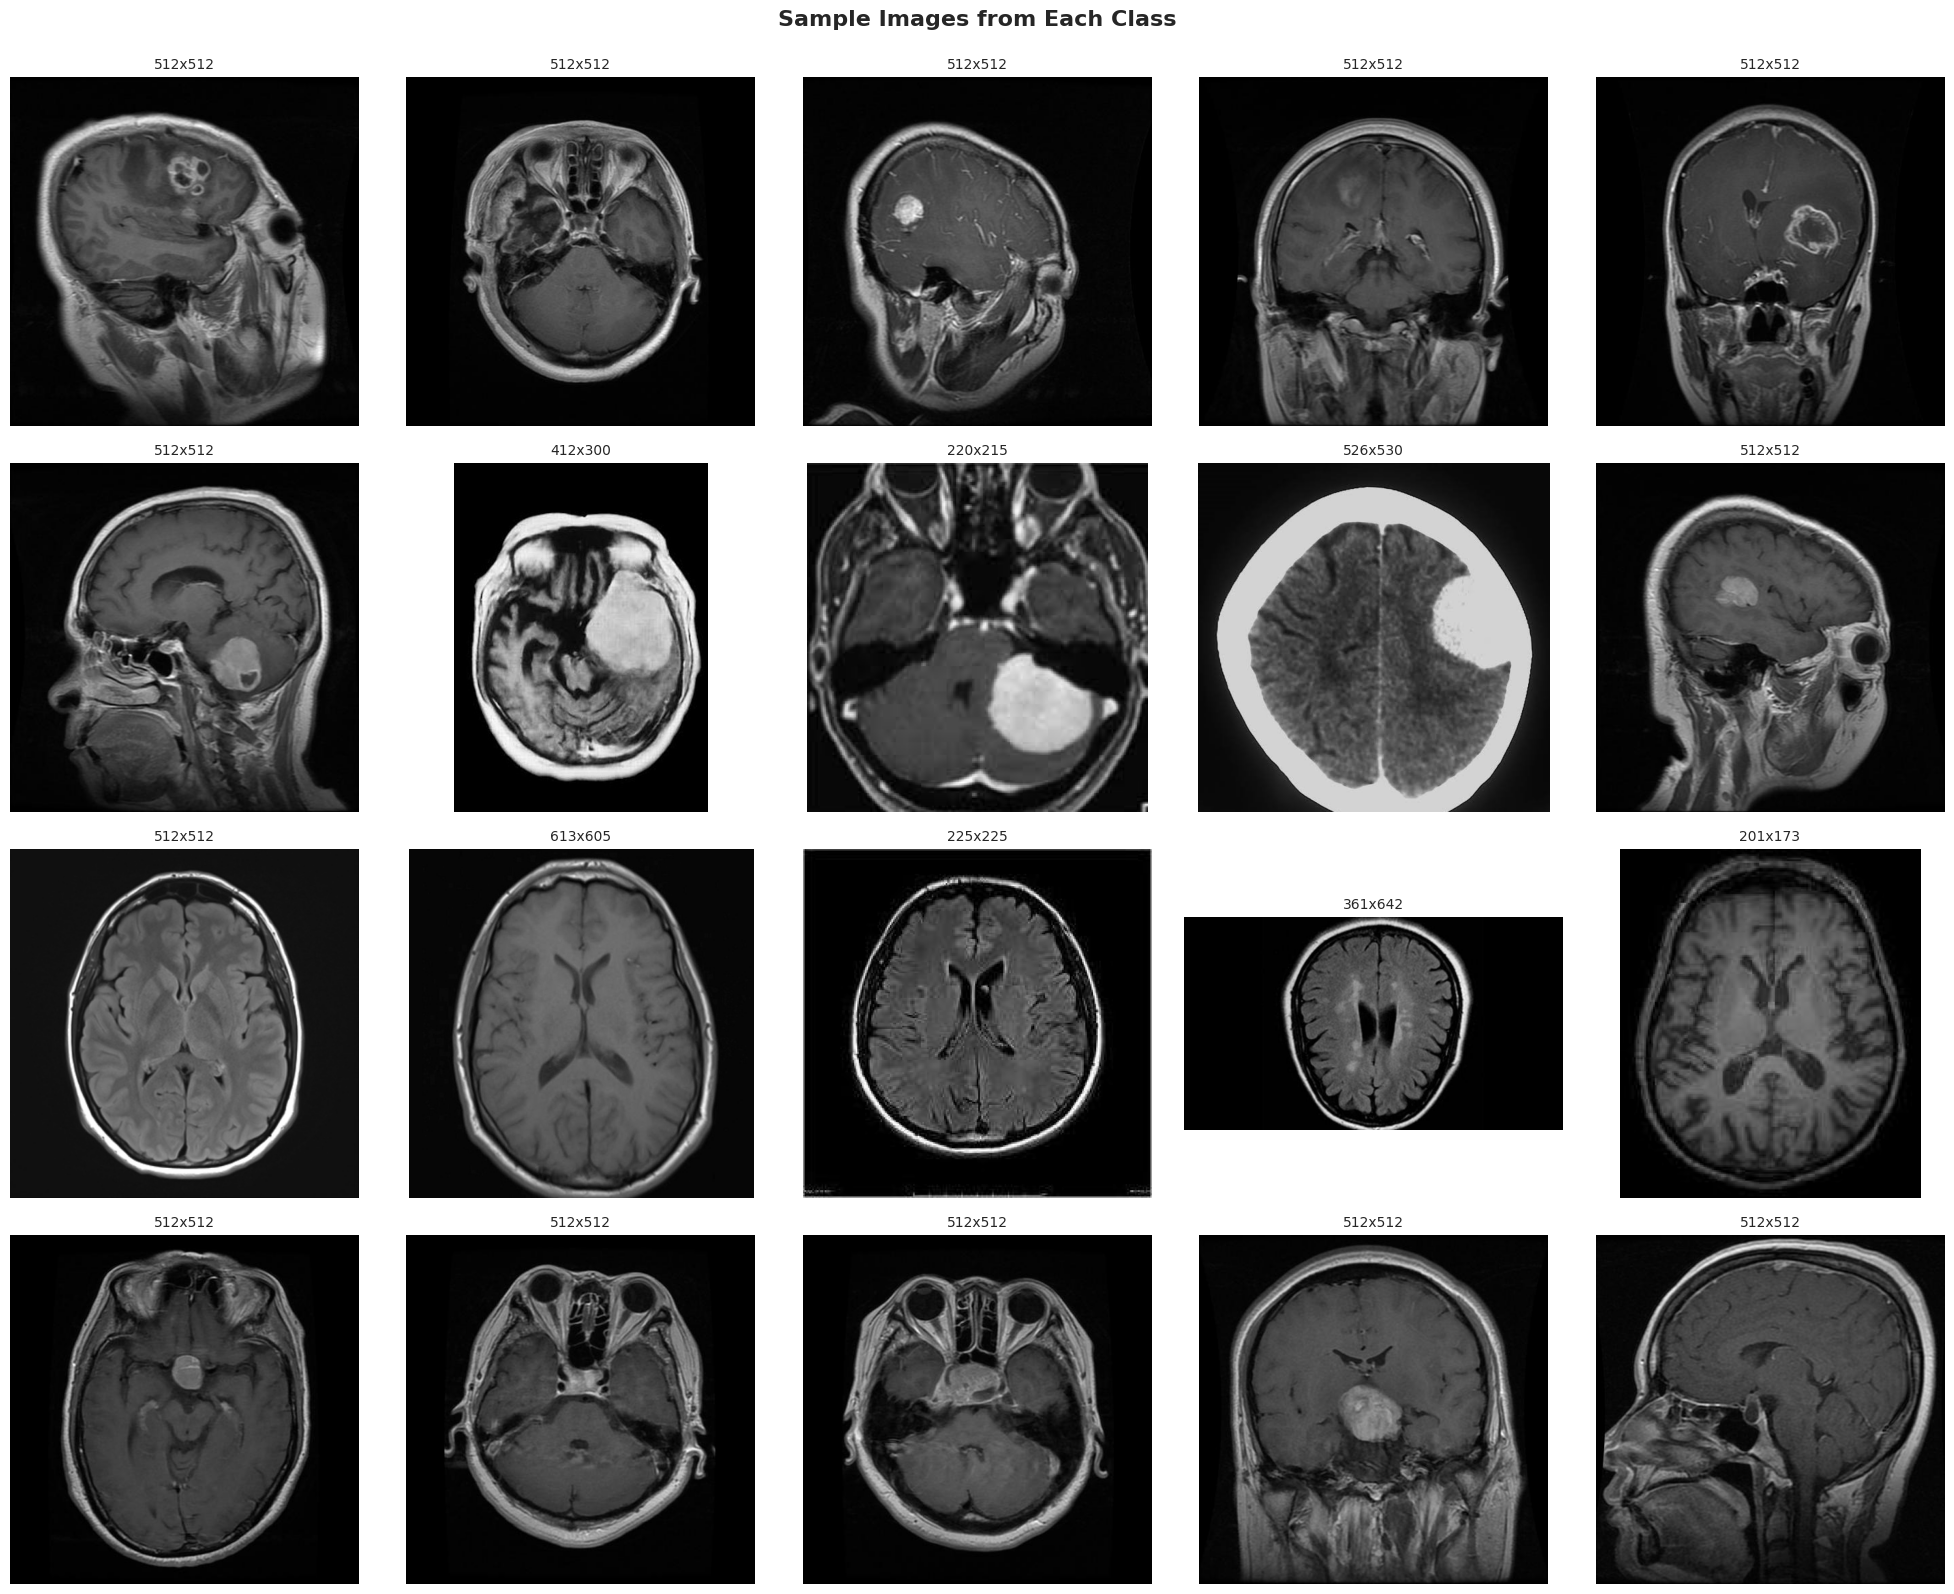

In [ ]:
def display_sample_images(train_dir, samples_per_class=5):
    """
    Display sample images from each class
    """
    classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

    fig, axes = plt.subplots(len(classes), samples_per_class, figsize=(20, 16))
    fig.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold', y=0.995)

    for i, cls in enumerate(classes):
        cls_path = os.path.join(train_dir, cls)
        images = os.listdir(cls_path)[:samples_per_class]

        for j, img_name in enumerate(images):
            img_path = os.path.join(cls_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            axes[i, j].imshow(img)
            axes[i, j].axis('off')

            if j == 0:
                axes[i, j].set_ylabel(cls.upper(), fontsize=14, fontweight='bold', rotation=0,
                                      labelpad=80, va='center')

            axes[i, j].set_title(f'{img.shape[0]}x{img.shape[1]}', fontsize=10)

    plt.tight_layout()
    plt.show()

print("\nDisplaying sample images...")
display_sample_images(TRAIN_DIR, samples_per_class=5)


### 7. Image Dimension Analysis

MRI scans often come in varying resolutions. We analyze the width, height, and aspect ratio of images to decide on a standard input size for the CNN.


Analyzing image dimensions...

IMAGE DIMENSIONS ANALYSIS
           width                       height                      
             min   max    mean     std    min   max    mean     std
class                                                              
glioma       512   512  512.00    0.00    512   512  512.00    0.00
meningioma   200   530  488.10   75.36    212   526  490.78   67.91
notumor      150   926  319.24  172.17    168  1075  323.48  165.38
pituitary    256  1365  508.58   74.97    256  1365  508.58   74.97


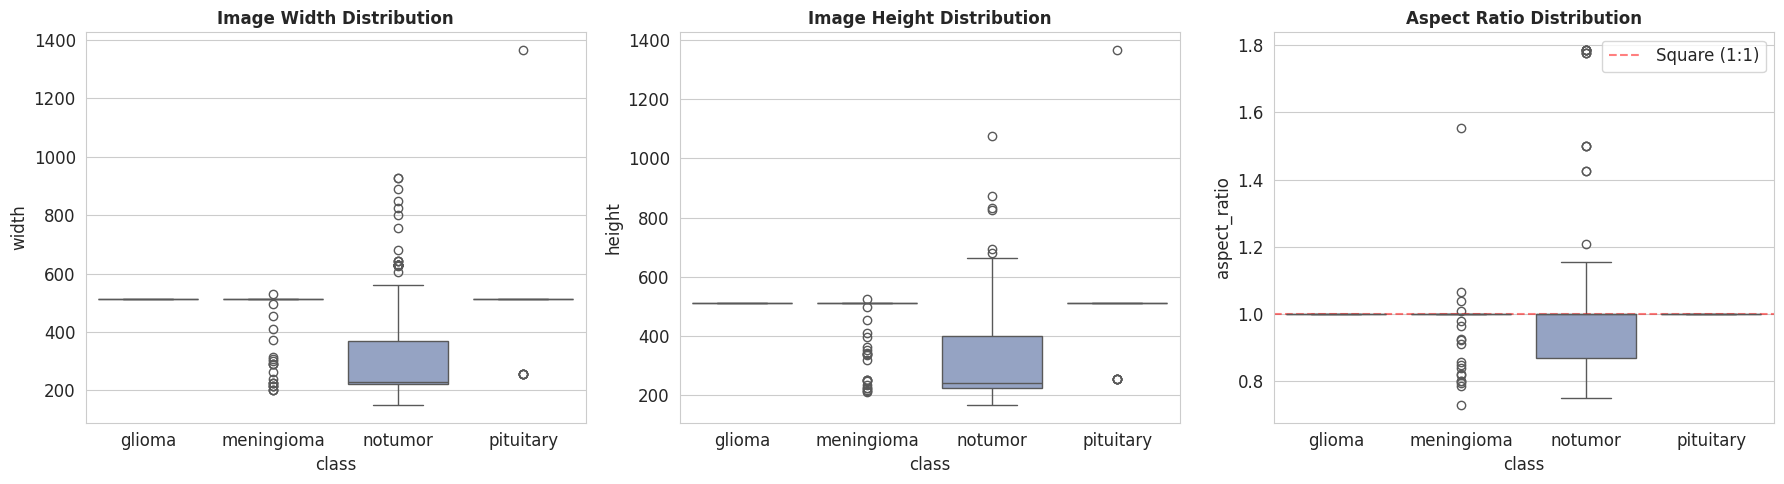

In [ ]:
def analyze_image_dimensions(train_dir, sample_size=200):
    """
    Analyze image dimensions across all classes
    """
    print("\nAnalyzing image dimensions...")

    classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
    dimensions = {'class': [], 'width': [], 'height': [], 'aspect_ratio': []}

    for cls in classes:
        cls_path = os.path.join(train_dir, cls)
        images = os.listdir(cls_path)[:sample_size]

        for img_name in images:
            img_path = os.path.join(cls_path, img_name)
            img = cv2.imread(img_path)

            if img is not None:
                h, w = img.shape[:2]
                dimensions['class'].append(cls)
                dimensions['width'].append(w)
                dimensions['height'].append(h)
                dimensions['aspect_ratio'].append(w/h)

    df_dims = pd.DataFrame(dimensions)
    return df_dims

df_dimensions = analyze_image_dimensions(TRAIN_DIR)

print("\nIMAGE DIMENSIONS ANALYSIS")
print(df_dimensions.groupby('class').agg({
    'width': ['min', 'max', 'mean', 'std'],
    'height': ['min', 'max', 'mean', 'std']
}).round(2))

# Visualize dimensions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(data=df_dimensions, x='class', y='width', palette='Set2', ax=axes[0])
axes[0].set_title('Image Width Distribution', fontsize=12, fontweight='bold')

sns.boxplot(data=df_dimensions, x='class', y='height', palette='Set2', ax=axes[1])
axes[1].set_title('Image Height Distribution', fontsize=12, fontweight='bold')

sns.boxplot(data=df_dimensions, x='class', y='aspect_ratio', palette='Set2', ax=axes[2])
axes[2].set_title('Aspect Ratio Distribution', fontsize=12, fontweight='bold')
axes[2].axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Square (1:1)')
axes[2].legend()

plt.tight_layout()
plt.show()

### 8. Data Preprocessing Setup

We define the global configuration for the preprocessing pipeline, including target image size and class mappings.

In [ ]:
print("\nPREPROCESSING CONFIGURATION")

# Configuration
IMG_SIZE = 224  # Standard size for transfer learning models
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.15

print(f"Target Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Validation Split: {VALIDATION_SPLIT * 100}%")

# Class mapping
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_to_idx = {name: idx for idx, name in enumerate(class_names)}
idx_to_class = {idx: name for name, idx in class_to_idx.items()}

print(f"\nClass Mapping:")
for name, idx in class_to_idx.items():
    print(f"   {idx}: {name}")


PREPROCESSING CONFIGURATION
Target Image Size: 224x224
Batch Size: 32
Validation Split: 15.0%

Class Mapping:
   0: glioma
   1: meningioma
   2: notumor
   3: pituitary


### 9. Image Loading and Pre-processing

We perform image reading, color space conversion (BGR to RGB), and resizing.

In [ ]:
def load_and_preprocess_data(data_dir, img_size=224):
    """
    Load all images and labels
    """
    images = []
    labels = []

    print("\nLoading images...")

    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        class_idx = class_to_idx[class_name]

        image_files = os.listdir(class_path)
        print(f"   Loading {class_name}: {len(image_files)} images")

        for img_name in image_files:
            img_path = os.path.join(class_path, img_name)

            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))

            images.append(img)
            labels.append(class_idx)

    return np.array(images), np.array(labels)

# Load training data
X_train_full, y_train_full = load_and_preprocess_data(TRAIN_DIR, IMG_SIZE)

print(f"\nData loaded successfully!")
print(f"   Shape: {X_train_full.shape}")
print(f"   Labels shape: {y_train_full.shape}")



Loading images...
   Loading glioma: 1321 images
   Loading meningioma: 1339 images
   Loading notumor: 1595 images
   Loading pituitary: 1457 images

Data loaded successfully!
   Shape: (5712, 224, 224, 3)
   Labels shape: (5712,)


### 10. Data Splitting and Normalization

The data is split into training and validation sets using a stratified approach. Pixel values are then normalized to the range [0, 1] to facilitate model training.

In [ ]:
print("\nSplitting data into train and validation sets...")

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=VALIDATION_SPLIT,
    stratify=y_train_full,
    random_state=42
)

print(f"\nData split completed!")
print(f"   Training set: {X_train.shape[0]} images")
print(f"   Validation set: {X_val.shape[0]} images")

# Normalization
print("\nNormalizing data...")
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=4)
y_val_cat = to_categorical(y_val, num_classes=4)

print(f"\nLabels converted to categorical")



Splitting data into train and validation sets...

Data split completed!
   Training set: 4855 images
   Validation set: 857 images

Normalizing data...

Labels converted to categorical


### 11. Data Augmentation

To improve the model's robustness and prevent overfitting, we configure an image augmentation pipeline for the training set.


DATA AUGMENTATION CONFIGURATION

Generating augmentation examples...


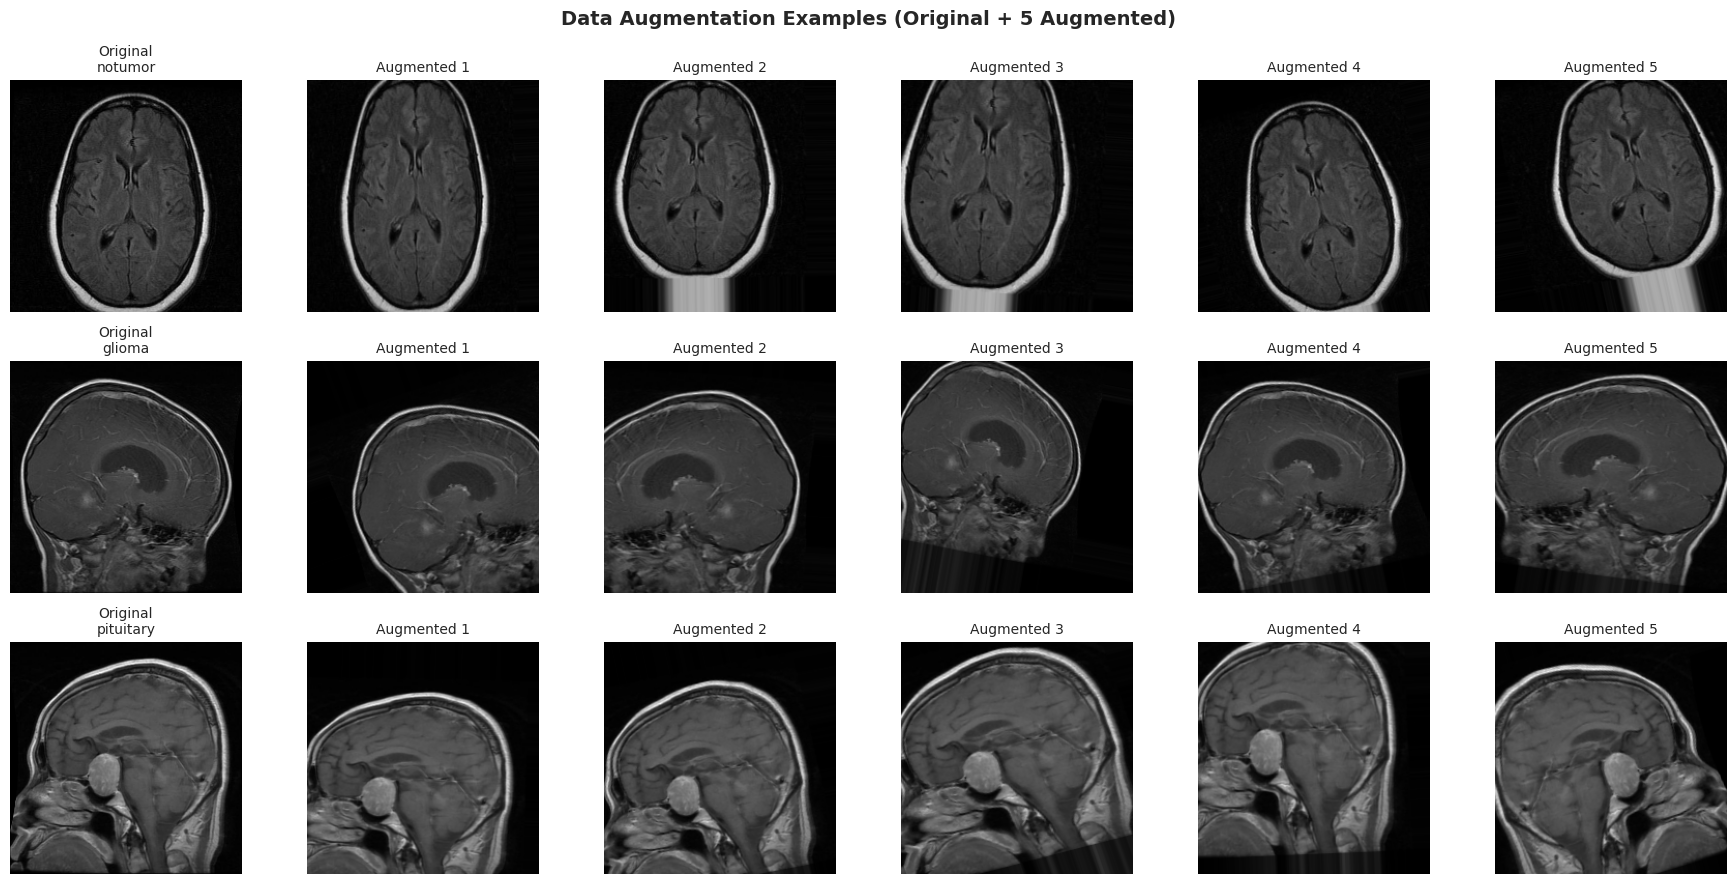

In [ ]:
print("\nDATA AUGMENTATION CONFIGURATION")

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

def visualize_augmentation(images, labels, datagen, num_examples=3):
    fig, axes = plt.subplots(num_examples, 6, figsize=(18, num_examples * 3))
    fig.suptitle('Data Augmentation Examples (Original + 5 Augmented)',
                 fontsize=14, fontweight='bold')

    for i in range(num_examples):
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title(f'Original\n{idx_to_class[labels[i]]}', fontsize=10)
        axes[i, 0].axis('off')

        img_expanded = images[i].reshape((1,) + images[i].shape)
        aug_iter = datagen.flow(img_expanded, batch_size=1)

        for j in range(1, 6):
            aug_img = next(aug_iter)[0]
            axes[i, j].imshow(aug_img)
            axes[i, j].set_title(f'Augmented {j}', fontsize=10)
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

print("\nGenerating augmentation examples...")
sample_indices = np.random.choice(len(X_train), 3, replace=False)
visualize_augmentation(X_train[sample_indices], y_train[sample_indices],
                        train_datagen, num_examples=3)


### 12. Saving Preprocessed Data

We save the preprocessed arrays and configuration to disk. This ensures that the next notebook can load the data directly for training.

In [ ]:
print("\nSAVING PREPROCESSED DATA")

os.makedirs('preprocessed_data', exist_ok=True)

# Save numpy arrays
np.save('preprocessed_data/X_train.npy', X_train)
np.save('preprocessed_data/X_val.npy', X_val)
np.save('preprocessed_data/y_train.npy', y_train)
np.save('preprocessed_data/y_val.npy', y_val)
np.save('preprocessed_data/y_train_cat.npy', y_train_cat)
np.save('preprocessed_data/y_val_cat.npy', y_val_cat)

# Save configuration
config = {
    'img_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'validation_split': VALIDATION_SPLIT,
    'num_classes': 4,
    'class_names': class_names,
    'class_to_idx': class_to_idx,
    'train_size': len(X_train),
    'val_size': len(X_val)
}

import json
with open('preprocessed_data/config.json', 'w') as f:
    json.dump(config, f, indent=4)

print("\nConfiguration saved: config.json")



SAVING PREPROCESSED DATA

Configuration saved: config.json


### 13. Test Set Preprocessing

Finally, we load and preprocess the independent testing set for final model evaluation.

In [ ]:
print("\nLOADING TEST DATA")

X_test, y_test = load_and_preprocess_data(TEST_DIR, IMG_SIZE)
X_test = X_test.astype('float32') / 255.0
y_test_cat = to_categorical(y_test, num_classes=4)

# Save test data
np.save('preprocessed_data/X_test.npy', X_test)
np.save('preprocessed_data/y_test.npy', y_test)
np.save('preprocessed_data/y_test_cat.npy', y_test_cat)

print("\nPREPROCESSING COMPLETED SUCCESSFULLY!")



LOADING TEST DATA

Loading images...
   Loading glioma: 300 images
   Loading meningioma: 306 images
   Loading notumor: 405 images
   Loading pituitary: 300 images

PREPROCESSING COMPLETED SUCCESSFULLY!


### 14. Create Downloadable ZIP File

To easily transfer the preprocessed data to other environments or for local storage, we can bundle the output directory into a single ZIP archive.

In [ ]:
import os
import shutil

print("CREATING DOWNLOADABLE ZIP FILE")

# Check if preprocessed_data folder exists
if not os.path.exists('preprocessed_data'):
    print("preprocessed_data folder not found")
else:
    print("\nFound preprocessed_data folder")

    # List files
    files = os.listdir('preprocessed_data')
    print(f"   Files: {len(files)}")
    for f in sorted(files):
        size = os.path.getsize(f'preprocessed_data/{f}') / (1024**2)
        print(f"   - {f:<25} ({size:.1f} MB)")

    # Remove old ZIP if exists
    if os.path.exists('preprocessed_data.zip'):
        os.remove('preprocessed_data.zip')

    # Create new ZIP
    shutil.make_archive('preprocessed_data', 'zip', '.', 'preprocessed_data')

    zip_size = os.path.getsize('preprocessed_data.zip') / (1024**2)

    print(f"ZIP file created")
    print(f"File: preprocessed_data.zip")
    print(f"Size: {zip_size:.1f} MB")
    print(f"Location: /content/preprocessed_data.zip")


CREATING DOWNLOADABLE ZIP FILE

Found preprocessed_data folder
   Files: 10
   - X_test.npy                (752.8 MB)
   - X_train.npy               (2787.8 MB)
   - X_val.npy                 (492.1 MB)
   - config.json               (0.0 MB)
   - y_test.npy                (0.0 MB)
   - y_test_cat.npy            (0.0 MB)
   - y_train.npy               (0.0 MB)
   - y_train_cat.npy           (0.1 MB)
   - y_val.npy                 (0.0 MB)
   - y_val_cat.npy             (0.0 MB)
ZIP file created
File: preprocessed_data.zip
Size: 371.2 MB
Location: /content/preprocessed_data.zip
